In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.linear_model import LinearRegression

from tqdm import tqdm_notebook as tqdm

## Loading and setting up the data

In [3]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [48]:
se_min = se.iloc[0:100000, :]

In [49]:
predict_array_median_chd = np.empty((se_min.shape[0],140)).astype(float)
predict_array_median_chd[:] = np.nan

predict_array_mean_chd = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_chd[:] = np.nan

# predict_array_median_c = np.empty((se_min.shape[0],140)).astype(float)
# predict_array_median_c[:] = np.nan

# predict_array_mean_c = np.empty((se_min.shape[0],140)).astype(float)
# predict_array_mean_c[:] = np.nan

predict_array_median_rules = np.empty((se_min.shape[0],140)).astype(float)
predict_array_median_rules[:] = np.nan

predict_array_mean_rules = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_rules[:] = np.nan

actual_array = np.empty((se_min.shape[0],140)).astype(float)
actual_array[:] = np.nan

In [50]:
# Rest the index so that it matches the index into the numpy array

se_min.reset_index(drop=True, inplace=True)

In [51]:
runs = se_min.groupby(['date','workid'])

In [52]:
for name, run in tqdm(runs):
    run = run.sort_values("actualArrival")
    

#     predict_array[run.index,0:2] = run[['median_durations_by_segment_code_and_hour_and_day', 'median_dwell_prev_by_stop_code_and_hour_and_day']]
    
#     actual_array[run.index,0:2] = run[['segment_duration', 'dwell_duration_prev']]

    run_length = len(run)
    
    for i in range(min([run_length, 70])):
        
        predict_array_median_chd[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['median_durations_by_segment_code_and_hour_and_day', 'median_dwell_prev_by_stop_code_and_hour_and_day']]
        
        predict_array_mean_chd[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day', 'mean_dwell_prev_by_stop_code_and_hour_and_day']]
        
#         predict_array_median_c[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['median_durations_by_segment_code', 'median_dwell_prev_durations_by_stop_code']]
        
#         predict_array_mean_c[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code', 'mean_dwell_prev_durations_by_stop_code']]
        
        predict_array_median_rules[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code', 'dwell_predict_rules_median']]
        
        predict_array_mean_rules[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code', 'dwell_predict_rules_mean']]
    
        actual_array[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['segment_duration', 'dwell_duration_prev']]
        

In [75]:
predict_array = None

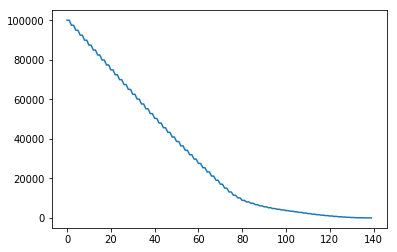

In [76]:
nans = []

for i in range(140):
    nans.append(predict_array_median_chd.shape[0] - np.count_nonzero(np.isnan(predict_array_median_chd[:,i])))
    
plt.plot(nans)

In [77]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    pass_percent = pass_count/np.count_nonzero(~np.isnan(actual)) * 100
    
    return pass_percent

In [78]:
def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy = percent_in_x_percent(predict[mask], actual[mask], j * 10)
    #         print(accuracy)
            accuracies_table[j-1,i] = accuracy

    return accuracies_table, frequency

In [79]:
def show_accuracy_minutes(predict, actual, title):
    results, frequency = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
#     ax = plt.gca()
    
#     ax2 = ax.twinx()
#     ax2.plot(frequency, label="frequency")
# #     ax2.yscale("log")
#     ax2.legend()

   
    plt.show()

In [80]:
predict_array_median_chd_cum = np.cumsum(predict_array_median_chd, axis=1)
predict_array_mean_chd_cum = np.cumsum(predict_array_mean_chd, axis=1)
# predict_array_median_c_cum = np.cumsum(predict_array_median_c, axis=1)
# predict_array_mean_c_cum = np.cumsum(predict_array_mean_c, axis=1)
predict_array_median_rules_cum = np.cumsum(predict_array_median_rules, axis=1)
predict_array_mean_rules_cum = np.cumsum(predict_array_mean_rules, axis=1)


actual_array_cum = np.cumsum(actual_array, axis=1)



In [81]:
predict_journey_median_chd_cum = np.cumsum(predict_array_median_chd[:, ::2], axis=1)
predict_journey_mean_chd_cum = np.cumsum(predict_array_mean_chd[:, ::2], axis=1)
actual_journey_cum = np.clip(np.cumsum(actual_array[:, ::2], axis=1), 0, 2*60*60)

predict_dwell_median_chd_cum = np.cumsum(predict_array_median_chd[:, 1::2], axis=1)
predict_dwell_mean_chd_cum = np.cumsum(predict_array_mean_chd[:, 1::2], axis=1)
actual_dwell_cum = np.clip(np.cumsum(actual_array[:, 1::2], axis=1), 0, 2*60*60)

In [82]:
predict_dwell_median_rules_cum = np.cumsum(predict_array_median_rules[:, 1::2], axis=1)
predict_dwell_mean_rules_cum = np.cumsum(predict_array_mean_rules[:, 1::2], axis=1)

In [83]:
actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)

.................................................................................................

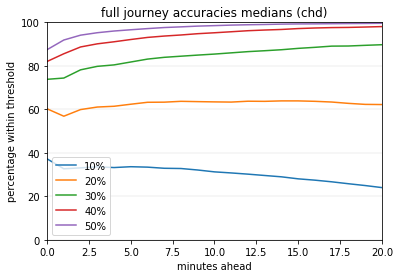

In [84]:
show_accuracy_minutes(predict_array_median_chd_cum, actual_array_cum, "full journey accuracies medians (chd)")

.................................................................................................

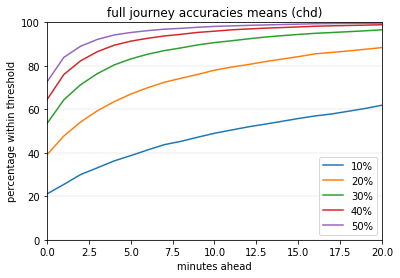

In [85]:
show_accuracy_minutes(predict_array_mean_chd_cum, actual_array_cum, "full journey accuracies means (chd)")

.................................................................................................

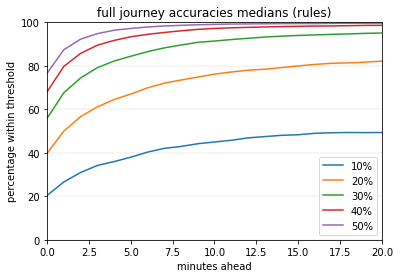

In [86]:
show_accuracy_minutes(predict_array_median_rules_cum, actual_array_cum, "full journey accuracies medians (rules)")

.................................................................................................

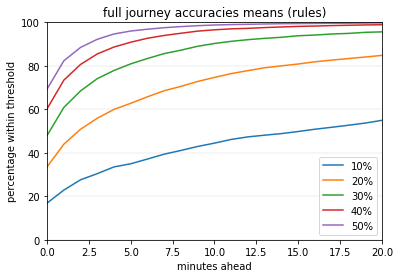

In [87]:
show_accuracy_minutes(predict_array_mean_rules_cum, actual_array_cum, "full journey accuracies means (rules)")

.........................................................................

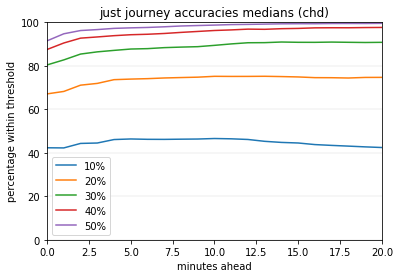

In [88]:
show_accuracy_minutes(predict_journey_median_chd_cum, actual_journey_cum, "just journey accuracies medians (chd)")


.........................................................................

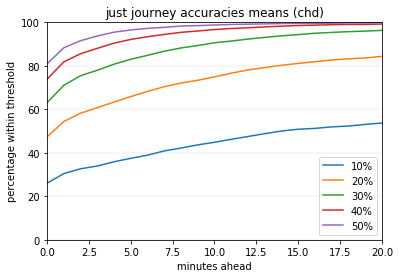

In [89]:
show_accuracy_minutes(predict_journey_mean_chd_cum, actual_journey_cum, "just journey accuracies means (chd)")

................................................

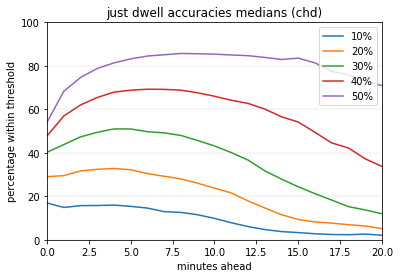

In [90]:
show_accuracy_minutes(predict_dwell_median_chd_cum, actual_dwell_cum, "just dwell accuracies medians (chd)")

................................................

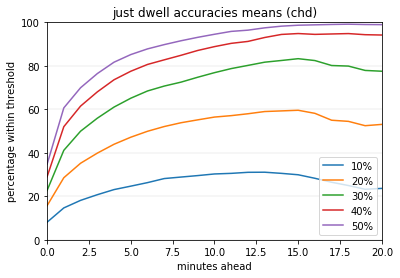

In [91]:
show_accuracy_minutes(predict_dwell_mean_chd_cum, actual_dwell_cum, "just dwell accuracies means (chd)")

................................................

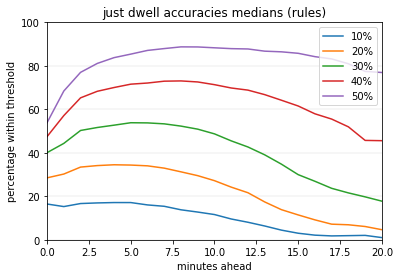

In [92]:
show_accuracy_minutes(predict_dwell_median_rules_cum, actual_dwell_cum, "just dwell accuracies medians (rules)")

................................................

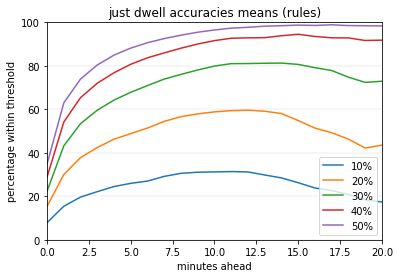

In [93]:
show_accuracy_minutes(predict_dwell_mean_rules_cum, actual_dwell_cum, "just dwell accuracies means (rules)")

In [94]:
predict_array_5 = predict_array_mean_chd.copy()

predict_array_5[:, 1::2] = 5

In [95]:
predict_array_5_cum = np.cumsum(predict_array_5, axis=1)

.................................................................................................

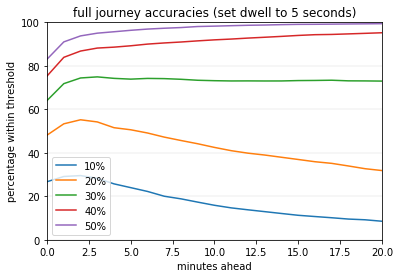

In [96]:
show_accuracy_minutes(predict_array_5_cum, actual_array_cum, "full journey accuracies (set dwell to 5 seconds)")